In [1]:
import pandas as pd
import numpy as np
import glob
import geopandas as gpd
import matplotlib.pyplot as plt
import geoplot as gplt
import shapefile
import osr
import dbf
import requests
import io

from urllib.request import urlopen
from zipfile import ZipFile
from shapely.geometry import shape, Point, Polygon


%matplotlib inline

In [2]:
countypairs = pd.read_csv('/home/jinli/PycharmProjects/county-pair-list.txt')
countypairs.drop_duplicates(subset='COUNTYPAIR_ID', inplace = True)

new = countypairs['COUNTYPAIR_ID'].str.split("-", n = 1, expand = True)

pairid = pd.concat([new[0], new[1]], ignore_index=True)
pairid = pairid.drop_duplicates()
pairid = pairid.to_frame('id')
pairid = pairid[~pairid['id'].isin(['06001', '06041', '06081','06075'])] ### county fips changed

### LAUS data (Unemployment Rate)

In [3]:
files = glob.glob('/home/jinli/Desktop/Thesis/Data/LAU(unemployment_rate)/*.csv')
dfs = [pd.read_csv(file) for file in files]
lausdata = pd.concat(dfs, ignore_index=True)

lausdata['GEOID10'] = lausdata['Series ID'].map(lambda x: x[5:10])
lausdata['STATEFP10'] = lausdata['GEOID10'].map(lambda x: x[0:2])
lausdata['COUNTYFP10'] = lausdata['GEOID10'].map(lambda x: x[2:])

lausdata = pd.merge(pairid, lausdata, how='left', left_on='id', right_on='GEOID10')
lausdata = lausdata.dropna()
### a = lausdata.GEOID10.unique()
### len(a)      1126

In [6]:
lausdata.to_csv('LAUS_COUNTY_MONTHLY_UNEMPLOYMENT.csv', index=False)

### GeoPlot: all states, all counties and broder counties

In [7]:
## All counties
allcounties = ZipFile('/home/jinli/PycharmProjects/tl_2010_us_county10(NEW).zip', 'r')

filenames_ac = [y for y in sorted(allcounties.namelist())
                 for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)]

dbf_ac, prj_ac, shp_ac, shx_ac = [io.BytesIO(allcounties.read(filename)) for filename in filenames_ac]

r_ac = shapefile.Reader(shp=shp_ac, shx=shx_ac, dbf=dbf_ac)
## r_ac.numRecords   ### 3221


attributes, geometry = [], []

field_names = [field[0] for field in r_ac.fields[1:]]

for row in r_ac.shapeRecords():
    geometry.append(shape(row.shape.__geo_interface__))
    attributes.append(dict(zip(field_names,row.record)))
    
prj = io.TextIOWrapper(prj_ac, encoding='utf-8')
proj4 = osr.SpatialReference(prj.read()).ExportToProj4()

gdf_ac = gpd.GeoDataFrame(data=attributes, geometry=geometry, crs=proj4)
gdf_ac.sort_values(by =['STATEFP10', 'COUNTYFP10'], inplace=True)
gdf_ac.reset_index(drop=True, inplace=True)
gdf_ac[['INTPTLON10', 'INTPTLAT10']] = gdf_ac[['INTPTLON10', 'INTPTLAT10']].apply(pd.to_numeric)

gdf_ac = gdf_ac[(gdf_ac.STATEFP10 != '02') & (gdf_ac.STATEFP10 != '72') & (gdf_ac.STATEFP10 != '15')]

In [8]:
## All states
allstates = ZipFile('/home/jinli/PycharmProjects/tl_2010_us_state10.zip', 'r')

filenames_as = [y for y in sorted(allstates.namelist())
                for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)]

dbf_as, prj_as, shp_as, shx_as = [io.BytesIO(allstates.read(filename)) for filename in filenames_as]

r_as = shapefile.Reader(shp=shp_as, shx=shx_as, dbf=dbf_as)

attributes, geometry = [], []

field_names = [field[0] for field in r_as.fields[1:]]
for row in r_as.shapeRecords():
    geometry.append(shape(row.shape.__geo_interface__))
    attributes.append(dict(zip(field_names,row.record)))
    
prj = io.TextIOWrapper(prj_as, encoding='utf-8')
proj4 = osr.SpatialReference(prj.read()).ExportToProj4()

gdf_as = gpd.GeoDataFrame(data=attributes, geometry=geometry, crs=proj4)
gdf_as = gdf_as[~gdf_as['STATEFP10'].isin(['02', '72', '15'])]
gdf_as.sort_values(by ='STATEFP10', ignore_index=True, inplace=True)

In [9]:
cp_list = lausdata.GEOID10.tolist()
cp_list = list(set(cp_list)) ## remove duplicates
#cp_list = [e for e in cp_list if e not in ('06001', '06041', '06081','06075')]

In [10]:
len(cp_list)

1126

In [11]:
gdf_cp = gdf_ac[gdf_ac['GEOID10'].isin(cp_list)]

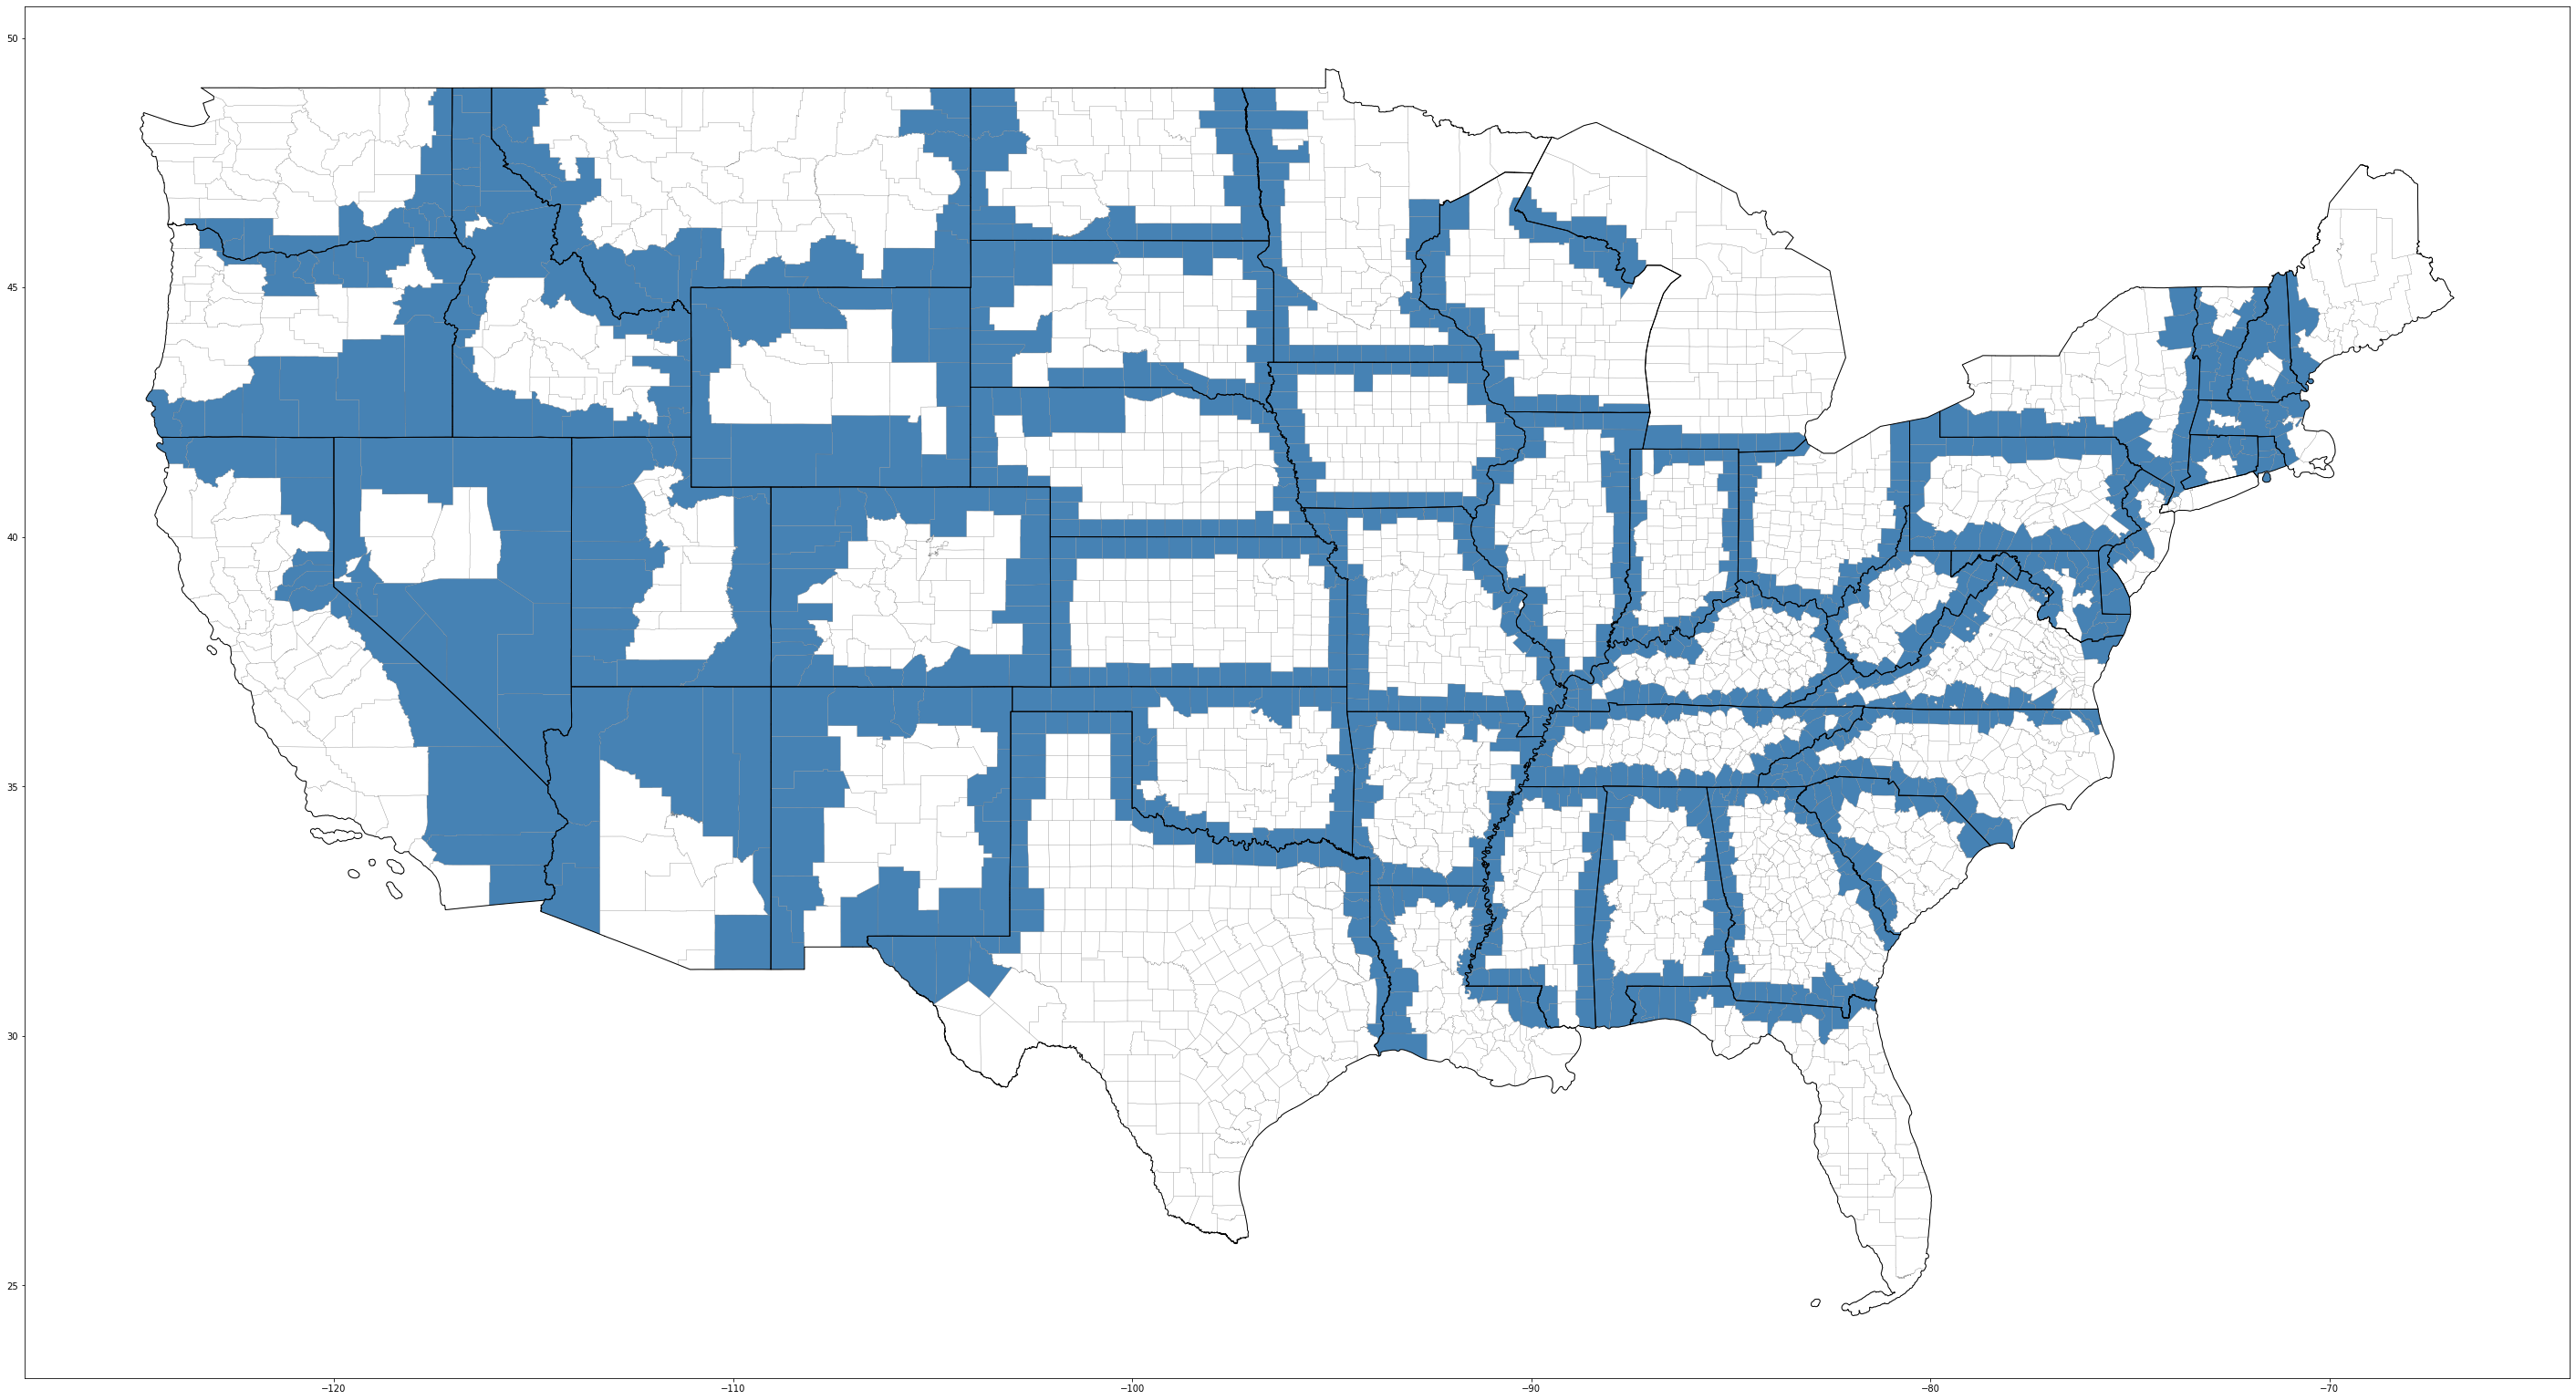

In [12]:
fig, ax = plt.subplots(figsize=(50,50))
gdf_cp.plot(ax=ax, color='steelblue', edgecolor='none')
gdf_ac.plot(ax=ax, facecolor='none', linewidth=0.2, edgecolor='grey')
gdf_as.plot(ax=ax, facecolor='none', linewidth=1, edgecolor='black')

fig.savefig('full_figure.pdf')